<a href="https://colab.research.google.com/github/anikdem01/blood_glucose_prediction/blob/main/lstm_timeseries_glucose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
train_csv_path = '/content/drive/MyDrive/ML/lstm_timeseries_glucose/brist1d/train.csv'
test_csv_path = '/content/drive/MyDrive/ML/lstm_timeseries_glucose/brist1d/test.csv'
sub_csv_path = '/content/drive/MyDrive/ML/lstm_timeseries_glucose/brist1d/sample_submission.csv'

In [33]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [34]:
df_train = pd.read_csv(train_csv_path, header=0, index_col=0)

<ipython-input-34-14ba99d5f92b>:1: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(train_csv_path, header=0, index_col=0)


In [83]:
df_train

,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p12_25294,p12,23:35:00,8.8,9.1,9.2,9.4,9.8,10.2,10.4,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.1
p12_25295,p12,23:40:00,9.1,9.2,9.4,9.8,10.2,10.4,10.3,10.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9
p12_25296,p12,23:45:00,9.2,9.4,9.8,10.2,10.4,10.3,10.1,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.7


# Multivariate

## Pre-processing

In [128]:
# Separating different categories of data

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

X_bg = imputer.fit_transform(df_train.filter(like='bg-'))

X_insulin = imputer.fit_transform(df_train.filter(like='insulin'))

X_cals = imputer.fit_transform(df_train.filter(like='cals'))

X_hr = imputer.fit_transform(df_train.filter(like='hr'))

X_time = df_train.filter(like='time')
X_time['time'] = pd.to_datetime(X_time['time'], format='%H:%M:%S')
X_time['time'] = X_time['time'].dt.hour * 60 + X_time['time'].dt.minute
X_time = imputer.fit_transform(X_time)

<ipython-input-128-febff16c219d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_time['time'] = pd.to_datetime(X_time['time'], format='%H:%M:%S')
<ipython-input-128-febff16c219d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_time['time'] = X_time['time'].dt.hour * 60 + X_time['time'].dt.minute


In [129]:
# shorten(arr, num) filters the last 5*num minutes of data
# Here we choose to just use the last 5*15 minutes of data for insulin and blood glucose

def shorten(arr, num):
    new_arr = []
    c = 0
    for i in arr:
        new_arr.append(arr[c][-num:])
        c += 1
    return new_arr



In [130]:
X_bg = shorten(X_bg, 10)
print(X_bg[0])

[17.5         8.21748321  8.22063294 17.3         8.21737625  8.21990337
 16.2         8.21704673  8.2188189  15.1       ]


In [131]:
X_insulin = shorten(X_insulin, 10)
print(X_insulin[0])

[0.0583 0.0583 0.0583 0.0583 0.0583 0.0583 0.0583 0.0583 0.0417 0.0417]


In [132]:
# Normalise data to z-score values

from sklearn.preprocessing import MinMaxScaler

def flatten_array(data_array):
    data_array = np.array(data_array, dtype=float)
    mean = np.mean(data_array)
    std_dev = np.std(data_array)
    normalized_array = (data_array - mean) / std_dev
    return normalized_array.tolist()

X_bg = flatten_array(X_bg)
X_insulin = flatten_array(X_insulin)

X_bg[0]

[3.3344242093347427,
 -0.008815960943401075,
 -0.007681539356989663,
 3.262391155219748,
 -0.008854485909349903,
 -0.00794430541785074,
 2.8662093575872754,
 -0.008973166102304012,
 -0.008334894396319669,
 2.4700275599548034]

In [133]:
X = np.hstack((X_bg, X_insulin))

y = df_train.iloc[:, -1:].values.flatten() # bg+1:00

X.shape, y.shape

((177024, 20), (177024,))

In [134]:
TRAIN = 140000
VAL = 20000
X_train, y_train = X[:TRAIN], y[:TRAIN]
X_val, y_val = X[TRAIN:TRAIN+VAL], y[TRAIN: TRAIN+VAL]
X_test, y_test = X[TRAIN+VAL:], y[TRAIN+VAL:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((140000, 20), (140000,), (20000, 20), (20000,), (17024, 20), (17024,))

In [135]:
X_train = X_train.reshape(140000, 20, 1)
X_val = X_val.reshape(20000, 20, 1)
X_test = X_test.reshape(17024, 20, 1)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((140000, 20, 1),
 (140000,),
 (20000, 20, 1),
 (20000,),
 (17024, 20, 1),
 (17024,))

## Building Model



In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

modelm = Sequential()
modelm.add(InputLayer((289, 1)))
modelm.add(LSTM(64))
modelm.add(Dense(8, 'relu'))
modelm.add(Dense(1, 'linear'))

modelm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [138]:
cp = ModelCheckpoint('modelm.keras', save_best_only=True)
modelm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

## Training and Evaluating Model

In [139]:
modelm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[cp])

Epoch 1/30
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 18.4782 - root_mean_squared_error: 4.0667 - val_loss: 4.8899 - val_root_mean_squared_error: 2.2113
Epoch 2/30
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 5.6589 - root_mean_squared_error: 2.3787 - val_loss: 4.8197 - val_root_mean_squared_error: 2.1954
Epoch 3/30
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 5.2057 - root_mean_squared_error: 2.2815 - val_loss: 4.3667 - val_root_mean_squared_error: 2.0897
Epoch 4/30
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 5.1102 - root_mean_squared_error: 2.2605 - val_loss: 4.3436 - val_root_mean_squared_error: 2.0841
Epoch 5/30
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 4.9650 - root_mean_squared_error: 2.2282 - val_loss: 4.2751 - val_root_mean_squared_error: 2.0676
Epoch 6/30
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 4.8900 - root_mean_squared_error: 2.2113 - val_loss: 4.5031 - val_root_mean_squared_error: 2.1220
Epoch 7/30
4375/4375 ━━━━━━━━━━━━

In [140]:
from tensorflow.keras.models import load_model
modelm = load_model('modelm.keras')

In [141]:
train_predictions = modelm.predict(X_train)

4375/4375 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [142]:
train_actual = y_train.flatten()
train_predictions = train_predictions.flatten()

# train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':train_actual})
# train_results

y_test = pd.DataFrame(train_actual)
y_pred = pd.DataFrame(train_predictions)

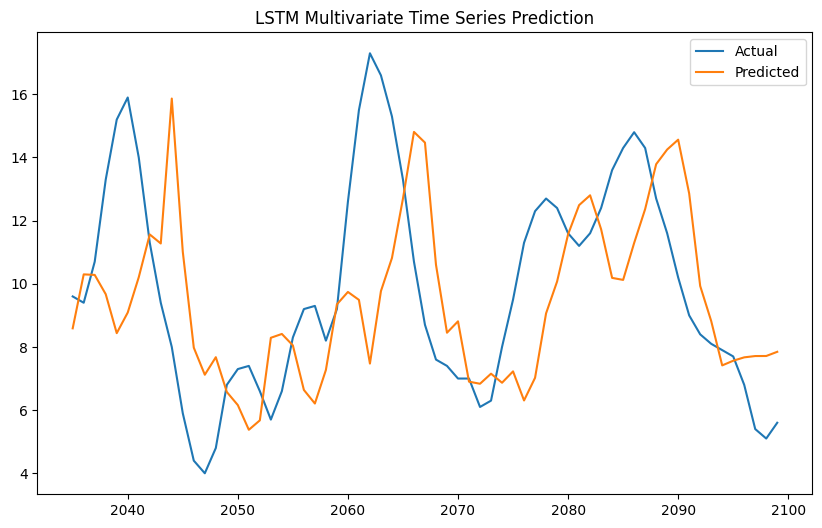

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

range1, range2 = 2035, 2100
plt.plot(y_test.index[range1:range2], y_test[range1:range2], label='Actual')
plt.plot(y_test.index[range1:range2], y_pred[range1:range2], label='Predicted')
plt.legend()
plt.title('LSTM Multivariate Time Series Prediction')
plt.show()

# XGBoost

## Pre-processing

In [22]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
# X2 = imputer.fit_transform(X)
# Z2 = imputer.transform(Z.values)

X_bg = imputer.fit_transform(df_train.filter(like='bg-'))

X_insulin = imputer.fit_transform(df_train.filter(like='insulin'))

X_cals = imputer.fit_transform(df_train.filter(like='cals'))

X_hr = imputer.fit_transform(df_train.filter(like='hr'))

X_time = df_train.filter(like='time')
X_time['time'] = pd.to_datetime(X_time['time'], format='%H:%M:%S')
X_time['time'] = X_time['time'].dt.hour * 60 + X_time['time'].dt.minute
X_time = imputer.fit_transform(X_time)

X = np.hstack((X_bg, X_insulin, X_cals))


y = df_train.iloc[:, -1:].values.flatten() # bg+1:00


X.shape, y.shape

<ipython-input-22-2a0eacb19d2f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_time['time'] = pd.to_datetime(X_time['time'], format='%H:%M:%S')
<ipython-input-22-2a0eacb19d2f>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_time['time'] = X_time['time'].dt.hour * 60 + X_time['time'].dt.minute


((177024, 216), (177024,))

In [23]:
TRAIN = 140000
VAL = 20000
X_train, y_train = X[:TRAIN], y[:TRAIN]
X_val, y_val = X[TRAIN:TRAIN+VAL], y[TRAIN: TRAIN+VAL]
X_test, y_test = X[TRAIN+VAL:], y[TRAIN+VAL:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((140000, 216), (140000,), (20000, 216), (20000,), (17024, 216), (17024,))

## Building, training and evaluating model

In [24]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 5,
    'subsample': 0.8
}

modelx = xgb.train(params, train_data, num_boost_round=100)

y_pred = modelx.predict(test_data)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 2.977258192792747


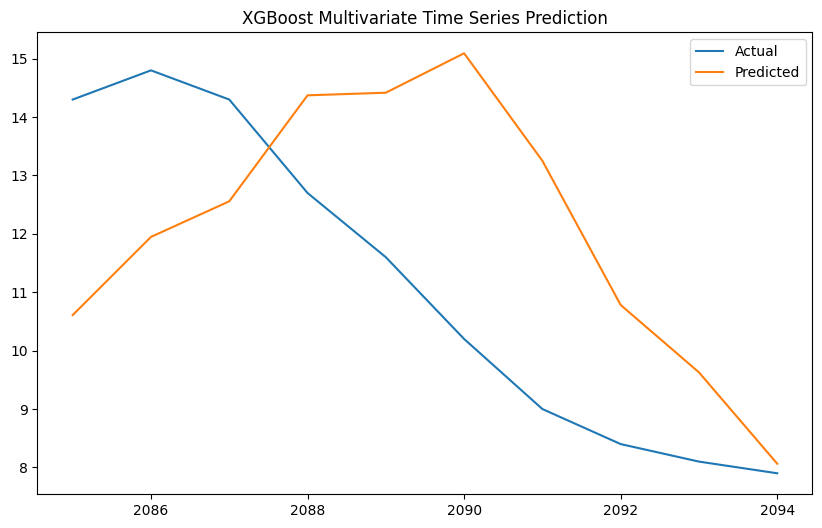

In [56]:
import matplotlib.pyplot as plt

y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred)

plt.figure(figsize=(10, 6))

range1, range2 = 2085, 2095
plt.plot(y_test.index[range1:range2], y_test[range1:range2], label='Actual')
plt.plot(y_test.index[range1:range2], y_pred[range1:range2], label='Predicted')
plt.legend()
plt.title('XGBoost Multivariate Time Series Prediction')
plt.show()